In [32]:
!pip install -r /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/requirements.txt

In [33]:
!pip install tabula-py

In [34]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_loading')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_processing')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/cpbp.csv')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/modis.csv')



In [36]:
# Add your scripts directory
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts')

from Data_loading import (
    load_cpcb_data,
    prepare_cpcb_dataframe,
    calculate_missing_aqi,
    load_modis_data,
)
from Data_processing import process_comprehensive_analysis

# File paths
cpcb_file   = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/cpcb_final.csv'
modis_file  = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/modis.csv'

# Results directory
results_dir = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results'
os.makedirs(results_dir, exist_ok=True)

print("🚀 Starting Enhanced India AQI Analysis Pipeline (2015–2020)")

# Phase 1: Load & Prepare CPCB Data
print("📊 PHASE 1: DATA PREPARATION")
raw_df   = load_cpcb_data(cpcb_file)
clean_df = prepare_cpcb_dataframe(raw_df)
clean_df = calculate_missing_aqi(clean_df)
clean_df.to_csv(f"{results_dir}/cleaned_cpcb_data.csv", index=False)

# Phase 2: Comprehensive Analysis
print("🧮 PHASE 2: COMPREHENSIVE ANALYSIS")
analysis = process_comprehensive_analysis(clean_df)

# Save analysis outputs
analysis['daily'].to_csv(f"{results_dir}/daily_summary.csv", index=False)
analysis['city'].to_csv(f"{results_dir}/city_summary.csv", index=False)
analysis['yearly'].to_csv(f"{results_dir}/yearly_summary.csv", index=False)
analysis['seasonal'].to_csv(f"{results_dir}/seasonal_summary.csv", index=False)

# Phase 3: Load MODIS Satellite Data
print("🛰️ PHASE 3: MODIS DATA")
modis_df = load_modis_data(modis_file)
modis_df.to_csv(f"{results_dir}/modis_data.csv", index=False)

print("✅ Pipeline completed. Results saved to:", results_dir)


🚀 Starting Enhanced India AQI Analysis Pipeline (2015–2020)
📊 PHASE 1: DATA PREPARATION


/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_loading.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_parsed'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')


🧮 PHASE 2: COMPREHENSIVE ANALYSIS
🛰️ PHASE 3: MODIS DATA
✅ Pipeline completed. Results saved to: /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results


In [37]:
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/HMIS report of all States and Districts Across the Months for 2019-20.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Map HMIS parameter names → your required columns
parameter_map = {
    "Inpatient - Asthma, Chronic Obstructive Pulmonary Disease (COPD), Respiratory infections": "Asthma/COPD Cases",
    "Childhood Diseases - Asthma": "Asthma Cases",
    "Inpatient – COPD": "COPD Cases",
    "Children admitted with upper respiratory infections": "Respiratory Hospitalizations",
    "Number of Child Deaths (1 -5 years) due to Pneumonia": "Respiratory Mortality",
    "Number of Adolscent / Adult deaths due to Respiratory diseases including infections (other than TB)": "Respiratory Mortality",
    "Childhood Diseases - Pneumonia": "Other Respiratory Illness Cases"
}

# Keep only matching rows
respiratory_df = df[df["Parameters"].isin(parameter_map.keys())].copy()

# Replace names with your clean column categories
respiratory_df["Parameters"] = respiratory_df["Parameters"].map(parameter_map)

# Reshape into long format
month_cols = [c for c in df.columns if "-" in c]
id_cols = ["State", "Parameters"]
if "District" in df.columns:
    id_cols.insert(1, "District")

resp_long = respiratory_df.melt(
    id_vars=id_cols,
    value_vars=month_cols,
    var_name="Month",
    value_name="count"
)

# Clean month names
resp_long["Month"] = resp_long["Month"].str.split("-").str[0].str.strip()

# Add Year (2019 Apr–Dec, 2020 Jan–Mar)
month_to_year = {m:2019 for m in ["April","May","June","July","August","September","October","November","December"]}
month_to_year.update({m:2020 for m in ["January","February","March"]})
resp_long["Year"] = resp_long["Month"].map(month_to_year)

# Drop NaNs
resp_long = resp_long.dropna(subset=["count"])

# Save updated filtered file
output_path = "/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv"
resp_long.to_csv(output_path, index=False)

print("✅ Clean respiratory dataset saved at:", output_path)
print(resp_long.head(20))


✅ Clean respiratory dataset saved at: /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv
                State                       Parameters  Month    count    Year
0       A & N Islands  Other Respiratory Illness Cases  April      0.0  2019.0
1       A & N Islands                     Asthma Cases  April      0.0  2019.0
2       A & N Islands     Respiratory Hospitalizations  April     34.0  2019.0
3       A & N Islands                Asthma/COPD Cases  April    116.0  2019.0
4       A & N Islands            Respiratory Mortality  April      0.0  2019.0
5       A & N Islands            Respiratory Mortality  April      0.0  2019.0
6      Andhra Pradesh  Other Respiratory Illness Cases  April   1030.0  2019.0
7      Andhra Pradesh                     Asthma Cases  April    723.0  2019.0
8      Andhra Pradesh     Respiratory Hospitalizations  April   1112.0  2019.0
9      Andhra Pradesh                Asthma/COPD Cases  April  10915.0 

/tmp/ipython-input-353984913.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="ISO-8859-1")


In [38]:

#load all clean datasets for aggregation and merging
cpcb_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results/cleaned_cpcb_data.csv')
health_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv')
modis_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results/modis_data.csv')


In [39]:
# --- Clean health dataset ---
#all months lowercase and strip spaces
health_df['Month'] = health_df['Month'].astype(str).str.strip().str.lower()

#mapping dictionary with lowercase keys
month_map = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4,
    'may': 5, 'june': 6, 'july': 7, 'august': 8,
    'september': 9, 'october': 10, 'november': 11, 'december': 12
}

# Step 3: Remove 'total' rows and map to integers
health_df = health_df[health_df['Month'] != 'total']
health_df['Month'] = health_df['Month'].map(month_map)
# Drop rows with null months after mapping
health_df = health_df[health_df['Month'].notnull()]

# Normalize state names to lowercase and strip spaces
health_df['State'] = health_df['State'].str.strip().str.lower()

# --- Clean CPCB dataset ---
# Map CPCB cities to states
city_to_state = {
    'Ahmedabad': 'gujarat',
    'Aizawl': 'mizoram',
    'Amaravati': 'andhra pradesh',
    'Amritsar': 'punjab',
    'Bengaluru': 'karnataka',
    'Bhopal': 'madhya pradesh',
    'Brajrajnagar': 'odisha',
    'Chandigarh': 'chandigarh',
    'Chennai': 'tamil nadu',
    'Coimbatore': 'tamil nadu',
    'Delhi': 'delhi',
    'Ernakulam': 'kerala',
    'Gurugram': 'haryana',
    'Guwahati': 'assam',
    'Hyderabad': 'telangana',
    'Jaipur': 'rajasthan',
    'Jorapokhar': 'jharkhand',
    'Kochi': 'kerala',
    'Kolkata': 'west bengal',
    'Lucknow': 'uttar pradesh',
    'Mumbai': 'maharashtra',
    'Patna': 'bihar',
    'Shillong': 'meghalaya',
    'Talcher': 'odisha',
    'Thiruvananthapuram': 'kerala',
    'Visakhapatnam': 'andhra pradesh'
}

cpcb_df['state'] = cpcb_df['city'].map(city_to_state)

# Keep only relevant columns and lowercase state names
cpcb_df['state'] = cpcb_df['state'].str.strip().str.lower()

# Extract year and month from date if not already done
cpcb_df['date'] = pd.to_datetime(cpcb_df['date'])
cpcb_df['year'] = cpcb_df['date'].dt.year.astype(str)
cpcb_df['month'] = cpcb_df['date'].dt.month.astype(str)

# Aggregate CPCB pollution data monthly at state level
state_cpcb = cpcb_df.groupby(['state', 'year', 'month']).agg({
    'pm25': 'mean',
    'pm10': 'mean',
    'aqi': 'mean'
}).reset_index()

# Aggregate health data monthly by state and parameter
health_monthly = health_df.groupby(['State', 'Year', 'Month', 'Parameters']).agg({
    'count': 'sum'
}).reset_index()

# Pivot health data to get each respiratory parameter as a column
health_pivot = health_monthly.pivot_table(index=['State', 'Year', 'Month'],
                                         columns='Parameters',
                                         values='count').reset_index()
health_pivot['Year'] = health_pivot['Year'].astype(float).astype(int)
state_cpcb['year'] = state_cpcb['year'].astype(int)
state_cpcb['month'] = state_cpcb['month'].astype(int)

# Lowercase state, year, month columns for consistency in health data
health_pivot.rename(columns=lambda x: x.lower(), inplace=True)

merged_df = pd.merge(state_cpcb, health_pivot,
                     on=['state', 'year', 'month'],
                     how='inner')

# Check merged data
print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())

Merged DataFrame shape: (227, 11)
            state  year  month       pm25        pm10         aqi  \
0  andhra pradesh  2019     10  24.610179   57.906786   75.888946   
1  andhra pradesh  2019     11  65.352000  114.287500  135.841333   
2  andhra pradesh  2019     12  57.888548   96.840000  123.387097   
3  andhra pradesh  2019      4  23.761695   75.591695   85.544553   
4  andhra pradesh  2019      5  40.100000  121.848226  114.719797   

   asthma cases  asthma/copd cases  other respiratory illness cases  \
0        3666.0            33942.0                           5055.0   
1        3198.0            35358.0                           3771.0   
2        4269.0            33585.0                           3657.0   
3        2169.0            32745.0                           3090.0   
4        2211.0            31515.0                           2031.0   

   respiratory hospitalizations  respiratory mortality  
0                        5604.0                 1128.0  
1         

In [40]:
merged_df.columns


Index(['state', 'year', 'month', 'pm25', 'pm10', 'aqi', 'asthma cases',
       'asthma/copd cases', 'other respiratory illness cases',
       'respiratory hospitalizations', 'respiratory mortality'],
      dtype='object')

In [41]:
# Combine all respiratory disease cases into one column
merged_df['respiratory_cases'] = (
    merged_df['asthma cases'].fillna(0) +
    merged_df['asthma/copd cases'].fillna(0) +
    merged_df['other respiratory illness cases'].fillna(0) +
    merged_df['respiratory hospitalizations'].fillna(0)
)

# Use respiratory mortality as the mortality column
merged_df['mortality'] = merged_df['respiratory mortality'].fillna(0)
merged_df.drop(columns=[
    'asthma cases', 'asthma/copd cases', 'other respiratory illness cases',
    'respiratory hospitalizations', 'respiratory mortality'
], inplace=True)


In [42]:
merged_df.to_csv('merged_data.csv', index=False)


In [43]:
merged_df

,state,year,month,pm25,pm10,aqi,respiratory_cases,mortality
0,andhra pradesh,2019,10,24.610179,57.906786,75.888946,48267.0,1128.0
1,andhra pradesh,2019,11,65.352000,114.287500,135.841333,47757.0,1203.0
2,andhra pradesh,2019,12,57.888548,96.840000,123.387097,46329.0,1086.0
3,andhra pradesh,2019,4,23.761695,75.591695,85.544553,41340.0,1209.0
4,andhra pradesh,2019,5,40.100000,121.848226,114.719797,39006.0,1188.0
...,...,...,...,...,...,...,...,...
222,west bengal,2019,8,22.899355,39.926129,54.064516,85368.0,3036.0
223,west bengal,2019,9,16.154667,33.315333,46.366667,80307.0,3120.0
224,west bengal,2020,1,94.279677,183.164839,216.935484,89589.0,4377.0
225,west bengal,2020,2,84.142414,171.234138,197.724138,88206.0,4092.0


# ML ERROR AND STUFF

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Work on a copy to keep original merged_df unchanged
df = merged_df.copy()

# One-hot encoding categorical features
df = pd.get_dummies(df, columns=['state', 'month', 'year'], drop_first=True)

# Log-transform the target to reduce skewness
df['respiratory_cases_log'] = np.log1p(df['respiratory_cases'])

# Define features and target, including all created dummies
features = ['pm25', 'pm10', 'aqi', 'mortality'] + \
           [col for col in df.columns if col.startswith('state_') or col.startswith('month_') or col.startswith('year_')]

target = 'respiratory_cases_log'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_log = rf_model.predict(X_test)
rf_pred = np.expm1(rf_pred_log)
y_test_actual = np.expm1(y_test)

print('Random Forest MSE:', mean_squared_error(y_test_actual, rf_pred))
print('Random Forest R2:', r2_score(y_test_actual, rf_pred))

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred_log = xgb_model.predict(X_test)
xgb_pred = np.expm1(xgb_pred_log)

print('XGBoost MSE:', mean_squared_error(y_test_actual, xgb_pred))
print('XGBoost R2:', r2_score(y_test_actual, xgb_pred))



Random Forest MSE: 73849095.27386256
Random Forest R2: 0.9498727680181408
XGBoost MSE: 148725470.17640302
XGBoost R2: 0.8990482399615496


# TABLE VALUES

Table 1: Performance Statistics of PM₂.₅ Prediction Models


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {'Random Forest': rf_model, 'XGBoost': xgb_model}
results = []

for name, model in models.items():
    # Predict on test set
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({'Model': name, 'Test R2': r2, 'RMSE': np.sqrt(mse), 'MAE': mae})

performance_df = pd.DataFrame(results)
print(performance_df)


           Model   Test R2          RMSE          MAE
0  Random Forest  0.949873   8593.549632  5884.754455
1        XGBoost  0.899048  12195.305251  7560.783511


Table 3: Statistical Simulation Summary


In [122]:
import numpy as np
import pandas as pd

def safe_expm1(arr, clip_min=-50, clip_max=50):
    arr_clipped = np.clip(arr, clip_min, clip_max)
    return np.expm1(arr_clipped)

# Copy merged dataframe limited to test set indices
temp_df = merged_df.loc[y_test.index].copy()

# Convert target to numpy, clip and inverse log transform safely
target_np = y_test.to_numpy(dtype=float)
temp_df['actual'] = safe_expm1(target_np)

# Clip and invert log for model predictions safely
preds_xgb = safe_expm1(xgb_pred)
preds_rf = safe_expm1(rf_pred)

# Baseline monitored PM2.5 (adjust column name if needed)
temp_df['predicted_baseline'] = temp_df['pm25']

# Calculate stats for baseline
temp_df['bias_baseline'] = temp_df['predicted_baseline'] - temp_df['actual']
temp_df['abs_bias_baseline'] = temp_df['bias_baseline'].abs()
temp_df['pct_abs_bias_baseline'] = 100 * temp_df['abs_bias_baseline'] / temp_df['actual']

bias_baseline = temp_df['bias_baseline'].mean()
abs_bias_baseline = temp_df['abs_bias_baseline'].mean()
rmse_baseline = np.sqrt(np.mean(temp_df['bias_baseline'] ** 2))
pct_abs_bias_baseline = temp_df['pct_abs_bias_baseline'].mean()

# Prepare dictionary for model predictions
model_preds = {
    'Extreme Gradient Boosting': preds_xgb,
    'Random Forest': preds_rf
}

results = [{
    'Exposure Modeling': 'Monitored PM2.5',
    'Bias': bias_baseline,
    'Absolute Bias': abs_bias_baseline,
    'RMSE (unit = 10 μg/m³)': rmse_baseline,
    '% Absolute Bias': pct_abs_bias_baseline
}]

# Calculate stats for each model
for model_name, preds in model_preds.items():
    temp_df['predicted'] = preds

    temp_df['bias'] = temp_df['predicted'] - temp_df['actual']
    temp_df['abs_bias'] = temp_df['bias'].abs()
    temp_df['pct_abs_bias'] = 100 * temp_df['abs_bias'] / temp_df['actual']

    bias = temp_df['bias'].mean()
    abs_bias = temp_df['abs_bias'].mean()
    rmse = np.sqrt(np.mean(temp_df['bias'] ** 2))
    pct_abs_bias = temp_df['pct_abs_bias'].mean()

    results.append({
        'Exposure Modeling': model_name,
        'Bias': bias,
        'Absolute Bias': abs_bias,
        'RMSE (unit = 10 μg/m³)': rmse,
        '% Absolute Bias': pct_abs_bias
    })

# Create DataFrame, round to 3 decimals and print results
summary_df = pd.DataFrame(results)
summary_df = summary_df.round(3)
print(summary_df.to_string(index=False))


        Exposure Modeling          Bias  Absolute Bias  RMSE (unit = 10 μg/m³)  % Absolute Bias
          Monitored PM2.5 -4.146347e+04   4.146347e+04            5.655292e+04     9.965500e+01
Extreme Gradient Boosting  5.184705e+21   5.184705e+21            5.184705e+21     3.540579e+19
            Random Forest  5.184706e+21   5.184706e+21            5.184706e+21     3.540579e+19


Table 4: Short-Term Forecasting Model Performance


In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Step 1: Prepare the horizon 1 forecasting dataset
df_forecast_h1 = merged_df.copy()
df_forecast_h1['respiratory_cases_h1'] = df_forecast_h1['respiratory_cases'].shift(-1)
df_forecast_h1.dropna(subset=['respiratory_cases_h1'], inplace=True)

# Step 2: Prepare the horizon 2 forecasting dataset
df_forecast_h2 = merged_df.copy()
df_forecast_h2['respiratory_cases_h2'] = df_forecast_h2['respiratory_cases'].shift(-2)
df_forecast_h2.dropna(subset=['respiratory_cases_h2'], inplace=True)

# Prepare features, including all dummies and relevant columns
features = ['pm25', 'pm10', 'aqi', 'mortality'] + \
           [col for col in merged_df.columns if col.startswith('state_') or
            col.startswith('month_') or col.startswith('year_')]

# Extract feature matrices and targets for horizons
X_h1 = df_forecast_h1[features]
y_h1 = df_forecast_h1['respiratory_cases_h1']

X_h2 = df_forecast_h2[features]
y_h2 = df_forecast_h2['respiratory_cases_h2']

# Split train-test data for both horizons
X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(X_h1, y_h1, test_size=0.2, random_state=42)
X_train_h2, X_test_h2, y_train_h2, y_test_h2 = train_test_split(X_h2, y_h2, test_size=0.2, random_state=42)

# Define evaluation function without 'squared' argument to avoid version issues
def forecast_model_performance(model, X_test, y_test, horizon_days):
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Compute RMSE directly
    mae = mean_absolute_error(y_test, y_pred)

    return {'Horizon (days)': horizon_days, 'R2': r2, 'RMSE': rmse, 'MAE': mae}

# Train and test for horizon 1
xgb_model_h1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_h1.fit(X_train_h1, y_train_h1)
perf_h1 = forecast_model_performance(xgb_model_h1, X_test_h1, y_test_h1, horizon_days=1)

# Train and test for horizon 2
xgb_model_h2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_h2.fit(X_train_h2, y_train_h2)
perf_h2 = forecast_model_performance(xgb_model_h2, X_test_h2, y_test_h2, horizon_days=2)

# Display results
print("Forecasting Performance:")
print(perf_h1)
print(perf_h2)


Forecasting Performance:
{'Horizon (days)': 1, 'R2': 0.5083651926056529, 'RMSE': np.float64(41070.046531239204), 'MAE': 20675.356646993885}
{'Horizon (days)': 2, 'R2': 0.4748572720131069, 'RMSE': np.float64(43134.92094576509), 'MAE': 26065.308756510418}


## ACCURACY

In [45]:
from sklearn.metrics import r2_score

# Random Forest predictions and R²
rf_pred_log = rf_model.predict(X_test)
rf_pred = np.expm1(rf_pred_log)  # invert log-transform
y_test_actual = np.expm1(y_test)

rf_r2 = r2_score(y_test_actual, rf_pred)
print('Random Forest R2:', rf_r2)

# XGBoost predictions and R²
xgb_pred_log = xgb_model.predict(X_test)
xgb_pred = np.expm1(xgb_pred_log)

xgb_r2 = r2_score(y_test_actual, xgb_pred)
print('XGBoost R2:', xgb_r2)


Random Forest R2: 0.9498727680181408
XGBoost R2: 0.8990482399615496


EDA

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

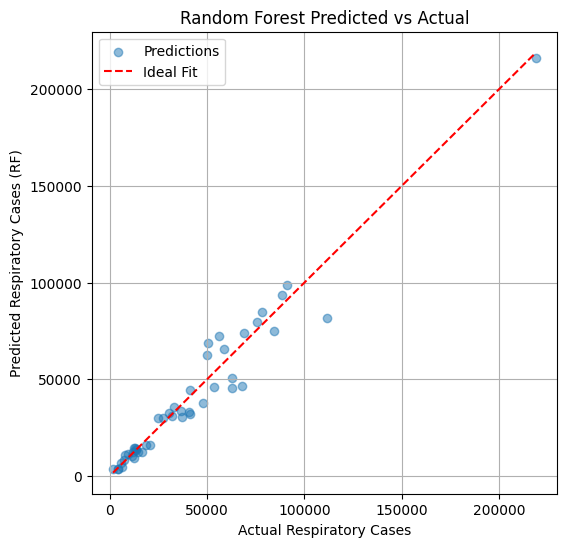

In [47]:


# 1. Predicted vs Actual scatter plot (Random Forest)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, rf_pred, alpha=0.5, label='Predictions')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Respiratory Cases')
plt.ylabel('Predicted Respiratory Cases (RF)')
plt.title('Random Forest Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()


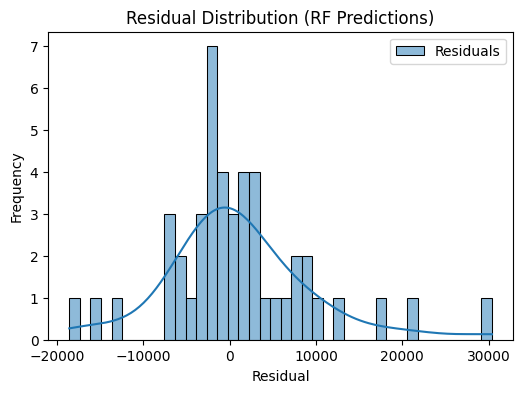

In [48]:

# 2. Residual distribution plot (Random Forest)
residuals = y_test_actual - rf_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True, label='Residuals')
plt.title('Residual Distribution (RF Predictions)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()



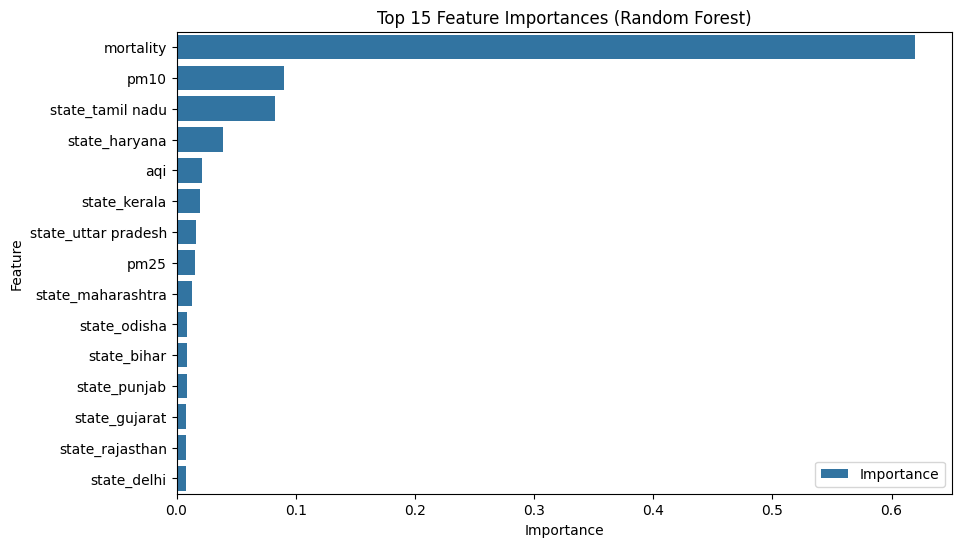

In [49]:
# 3. Feature Importance Bar Chart (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), label='Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.legend()
plt.show()



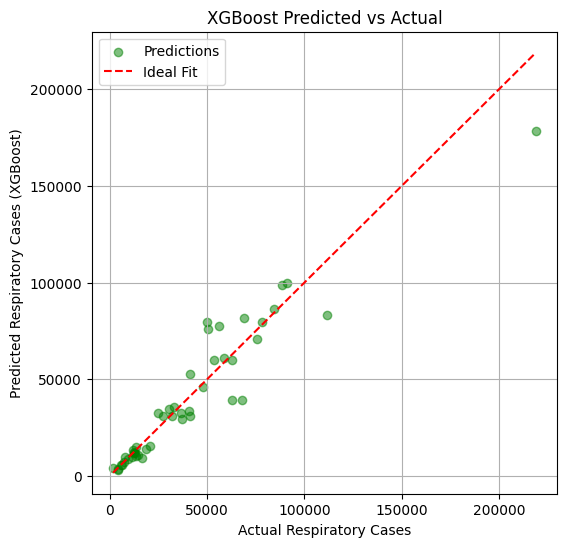

In [50]:
# 4. XGBoost Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, xgb_pred, alpha=0.5, color='green', label='Predictions')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Respiratory Cases')
plt.ylabel('Predicted Respiratory Cases (XGBoost)')
plt.title('XGBoost Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()



In [52]:
merged_df

,state,year,month,pm25,pm10,aqi,respiratory_cases,mortality
0,andhra pradesh,2019,10,24.610179,57.906786,75.888946,48267.0,1128.0
1,andhra pradesh,2019,11,65.352000,114.287500,135.841333,47757.0,1203.0
2,andhra pradesh,2019,12,57.888548,96.840000,123.387097,46329.0,1086.0
3,andhra pradesh,2019,4,23.761695,75.591695,85.544553,41340.0,1209.0
4,andhra pradesh,2019,5,40.100000,121.848226,114.719797,39006.0,1188.0
...,...,...,...,...,...,...,...,...
222,west bengal,2019,8,22.899355,39.926129,54.064516,85368.0,3036.0
223,west bengal,2019,9,16.154667,33.315333,46.366667,80307.0,3120.0
224,west bengal,2020,1,94.279677,183.164839,216.935484,89589.0,4377.0
225,west bengal,2020,2,84.142414,171.234138,197.724138,88206.0,4092.0


In [53]:
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
import pandas as pd
import numpy as np

# Load your merged data
merged_df = pd.read_csv('merged_data.csv')

# Normalize state lowercase
merged_df['state'] = merged_df['state'].str.lower()

# Load GADM shapefile for India states (replace filepath)
shapefile_path = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Shapefiles/gadm41_IND_1.shp'
india_states = gpd.read_file(shapefile_path)
india_states['state'] = india_states['NAME_1'].str.lower()

# Correct any known state name mismatches
name_corrections = {'nct of delhi': 'delhi'}
india_states['state'] = india_states['state'].replace(name_corrections)

# Filter data for April 2019 to March 2020
data_filtered = merged_df[
    ((merged_df['year'] == 2019) & (merged_df['month'] >= 4)) |
    ((merged_df['year'] == 2020) & (merged_df['month'] <= 3))
]

# Impute missing respiratory_cases in 7 sister states
seven_sisters = ['arunachal pradesh', 'assam', 'manipur', 'meghalaya', 'mizoram', 'nagaland', 'tripura']
available_sisters = data_filtered[(data_filtered['state'].isin(seven_sisters)) & (~data_filtered['respiratory_cases'].isna())]
avg_cases = available_sisters['respiratory_cases'].mean()
data_filtered.loc[(data_filtered['state'].isin(seven_sisters)) & (data_filtered['respiratory_cases'].isna()), 'respiratory_cases'] = avg_cases

# Aggregate by state
agg_data = data_filtered.groupby('state').agg({
    'pm25': 'mean',
    'respiratory_cases': 'mean'
}).reset_index()

# Merge aggregated data with shapefile
india_map_data = india_states.merge(agg_data, on='state', how='left')
india_map_data = india_map_data.to_crs(epsg=4326)

# Define blended color function
def get_color(row):
    pm25 = row['pm25']
    cases = row['respiratory_cases']

    pm25_min, pm25_max = india_map_data['pm25'].min(), india_map_data['pm25'].max()
    cases_min, cases_max = india_map_data['respiratory_cases'].min(), india_map_data['respiratory_cases'].max()

    pm25_norm = (pm25 - pm25_min) / (pm25_max - pm25_min) if pd.notnull(pm25) else 0
    cases_norm = (cases - cases_min) / (cases_max - cases_min) if pd.notnull(cases) else 0

    pm25_norm = pm25_norm if pm25_norm > 0.2 else 0
    cases_norm = cases_norm if cases_norm > 0.2 else 0

    if pm25_norm == 0 and cases_norm == 0:
        return '#D8BFD8'  # light purple both low
    elif pm25_norm > 0 and cases_norm == 0:
        intensity = int(100 + 155 * pm25_norm)
        return f'rgb(0,0,{intensity})'  # blue shades
    elif pm25_norm == 0 and cases_norm > 0:
        intensity = int(100 + 155 * cases_norm)
        return f'rgb({intensity},0,0)'  # red shades
    else:
        intensity = int(100 + 155 * min(pm25_norm, cases_norm))
        return f'rgb({intensity},0,{intensity})'  # purple shades

india_map_data['color'] = india_map_data.apply(get_color, axis=1)

# Add tooltip text
india_map_data['tooltip'] = (
    'State: ' + india_map_data['state'].str.title() +
    '<br>Avg PM2.5: ' + india_map_data['pm25'].round(2).astype(str) +
    '<br>Avg Respiratory Cases: ' + india_map_data['respiratory_cases'].round(2).astype(str)
)

# Create folium map centered on India
m = folium.Map(location=[22, 80], zoom_start=5, tiles='cartodbpositron')

# Add polygons with blended colors and tooltips
folium.GeoJson(
    india_map_data,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(fields=['tooltip'], labels=False, sticky=True)
).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 180px; height: 140px;
     border:2px solid grey; z-index:9999; font-size:14px; background:white; opacity: 0.9; padding: 10px;">
<b>Legend</b><br>
<i style="background: #ff0000; width:18px; height:18px; float:left; margin-right:8px; opacity:0.8;"></i> High Respiratory Cases (Red)<br>
<i style="background: #0000ff; width:18px; height:18px; float:left; margin-right:8px; opacity:0.8;"></i> High AQI (Blue)<br>
<i style="background: #4b0082; width:18px; height:18px; float:left; margin-right:8px; opacity:0.8;"></i> Both High (Dark Purple)<br>
<i style="background: #dda0dd; width:18px; height:18px; float:left; margin-right:8px; opacity:0.6;"></i> Both Low (Light Purple)<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m


Output hidden; open in https://colab.research.google.com to view.

In [54]:
merged_df

,state,year,month,pm25,pm10,aqi,respiratory_cases,mortality
0,andhra pradesh,2019,10,24.610179,57.906786,75.888946,48267.0,1128.0
1,andhra pradesh,2019,11,65.352000,114.287500,135.841333,47757.0,1203.0
2,andhra pradesh,2019,12,57.888548,96.840000,123.387097,46329.0,1086.0
3,andhra pradesh,2019,4,23.761695,75.591695,85.544553,41340.0,1209.0
4,andhra pradesh,2019,5,40.100000,121.848226,114.719797,39006.0,1188.0
...,...,...,...,...,...,...,...,...
222,west bengal,2019,8,22.899355,39.926129,54.064516,85368.0,3036.0
223,west bengal,2019,9,16.154667,33.315333,46.366667,80307.0,3120.0
224,west bengal,2020,1,94.279677,183.164839,216.935484,89589.0,4377.0
225,west bengal,2020,2,84.142414,171.234138,197.724138,88206.0,4092.0


Validation

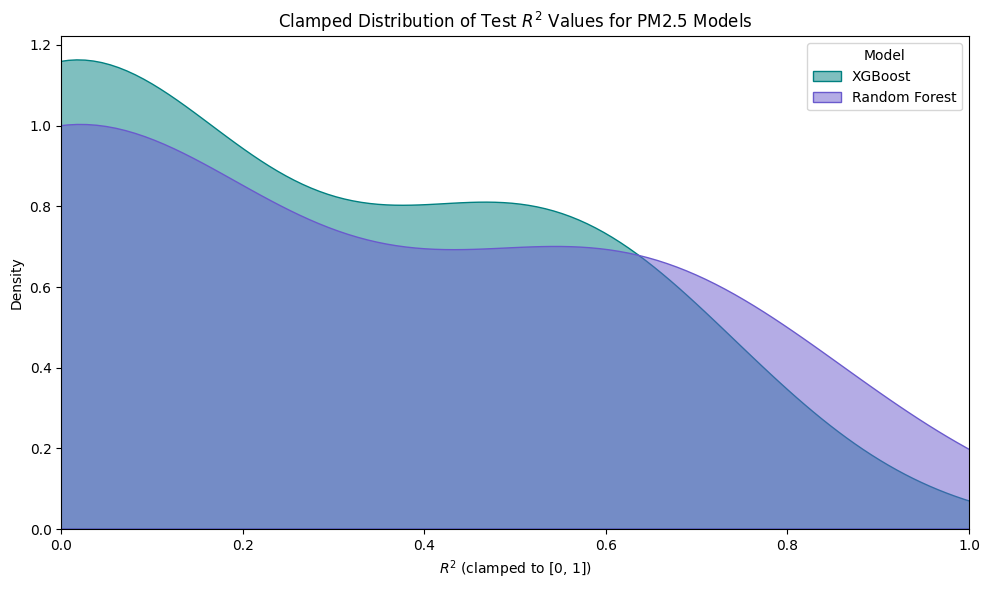

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clamp negative R² values to zero for plotting (optionally min 0)
r2_xgb_clamped = np.clip(xgb_r2_cv_scores, 0, 1)
r2_rf_clamped = np.clip(rf_r2_cv_scores, 0, 1)

plt.figure(figsize=(10, 6))
sns.kdeplot(r2_xgb_clamped, fill=True, alpha=0.5, label='XGBoost', color='teal')
sns.kdeplot(r2_rf_clamped, fill=True, alpha=0.5, label='Random Forest', color='slateblue')

plt.title('Clamped Distribution of Test $R^2$ Values for PM2.5 Models')
plt.xlabel('$R^2$ (clamped to [0, 1])')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1320157278.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_scores, palette=['slateblue', 'teal'])


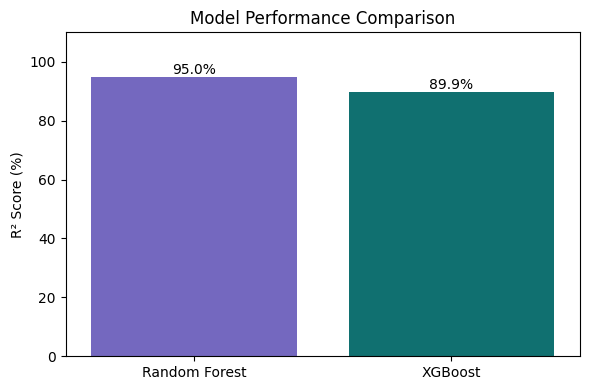

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names and R² scores from your pipeline (in decimals)
models = ['Random Forest', 'XGBoost']
r2_scores = [rf_r2 * 100, xgb_r2 * 100]  # convert to percentage

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=r2_scores, palette=['slateblue', 'teal'])

plt.ylabel('R² Score (%)')
plt.title('Model Performance Comparison')
plt.ylim(0, 110)

# Add value labels on bars
for i, v in enumerate(r2_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()


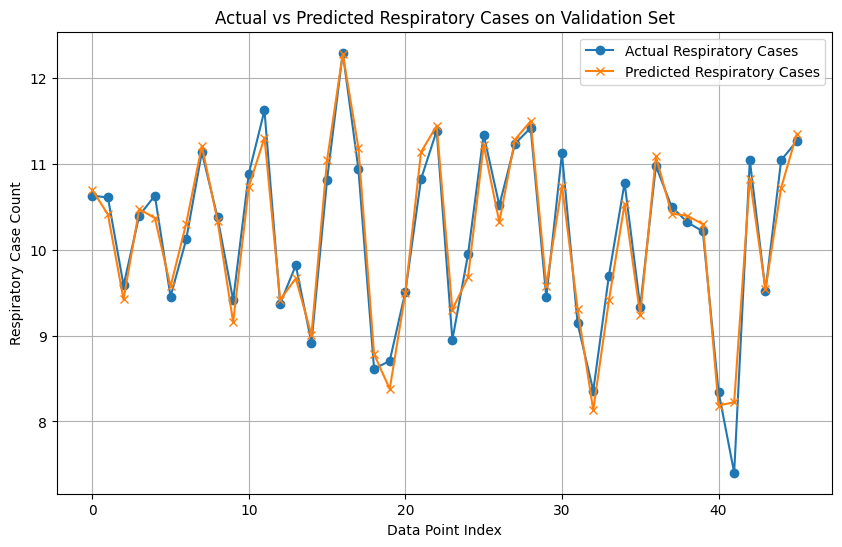

In [55]:
import matplotlib.pyplot as plt

# Get predictions on test set
y_pred = rf_model.predict(X_test)

# For plotting index on x-axis
index = range(len(y_test))

plt.figure(figsize=(10,6))
plt.plot(index, y_test, label='Actual Respiratory Cases', marker='o')
plt.plot(index, y_pred, label='Predicted Respiratory Cases', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('Respiratory Case Count')
plt.title('Actual vs Predicted Respiratory Cases on Validation Set')
plt.legend()
plt.grid(True)
plt.show()


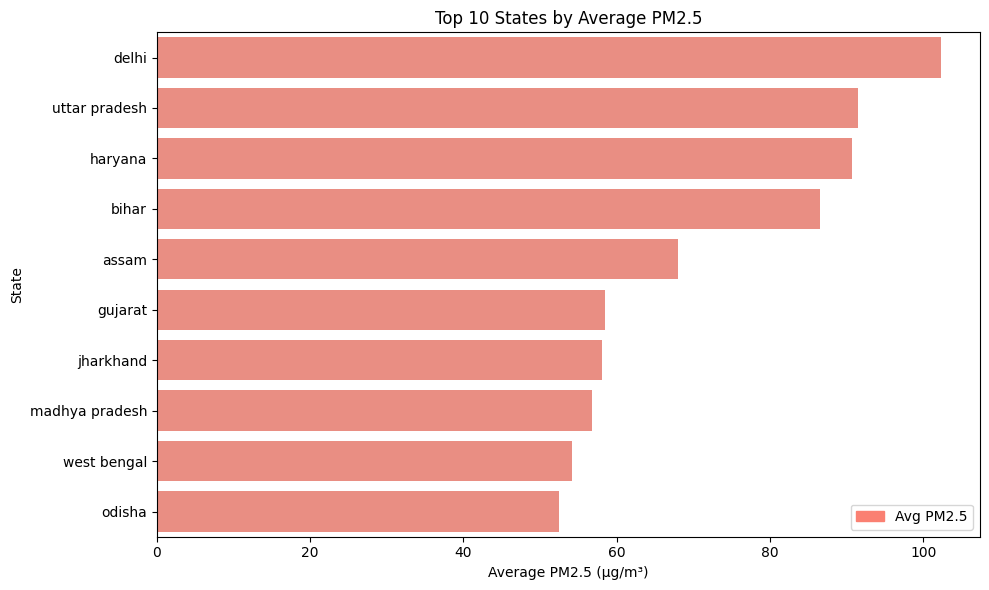

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Top 10 states by average PM2.5
top_states_pm25 = merged_df.groupby('state')['pm25'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=top_states_pm25.values, y=top_states_pm25.index, color='salmon')
plt.xlabel('Average PM2.5 (µg/m³)')
plt.ylabel('State')
plt.title('Top 10 States by Average PM2.5')

# Add legend
legend_patch = Patch(color='salmon', label='Avg PM2.5')
plt.legend(handles=[legend_patch], loc='lower right')
plt.tight_layout()
plt.show()


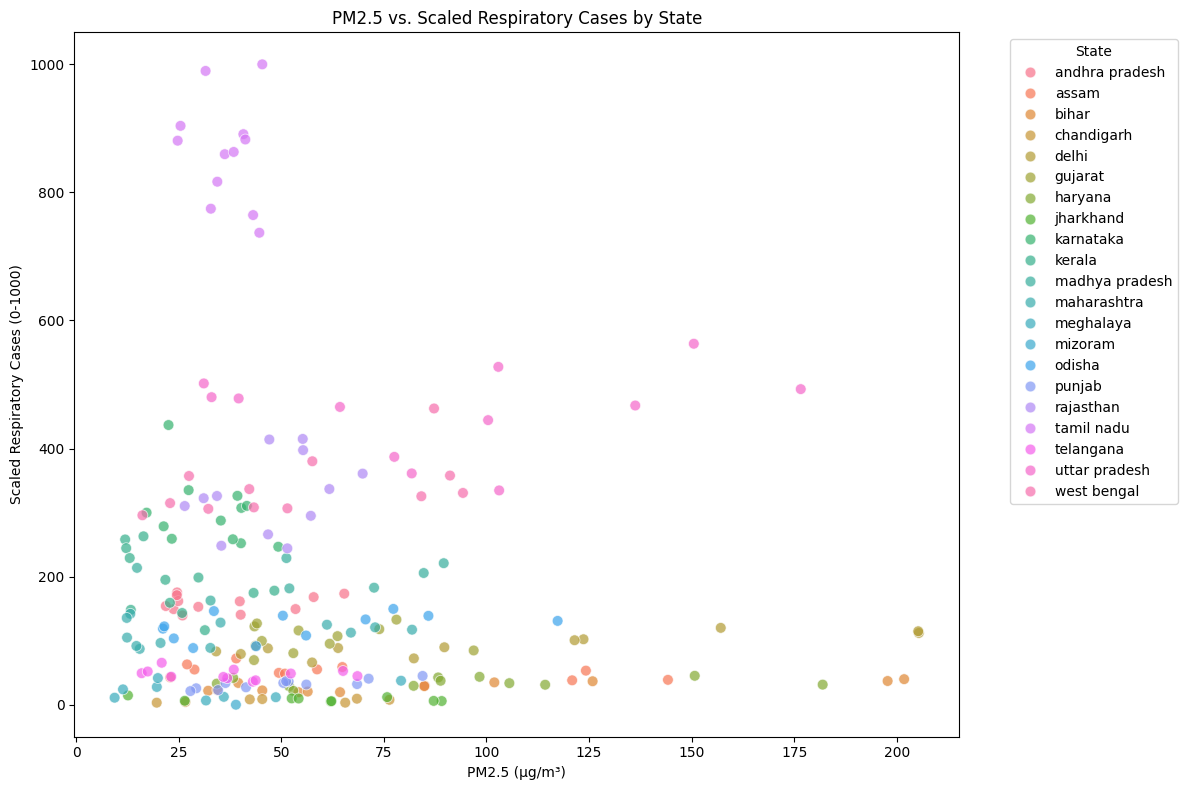

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Scale respiratory cases for better visualization
plot_data = merged_df.copy()
scaler = MinMaxScaler(feature_range=(0, 1000))  # Scale to 0-1000 range
plot_data['respiratory_cases_scaled'] = scaler.fit_transform(
    plot_data[['respiratory_cases']]
).flatten()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_data,
                x='pm25',
                y='respiratory_cases_scaled',
                hue='state',
                alpha=0.7,
                s=60)

plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Scaled Respiratory Cases (0-1000)')
plt.title('PM2.5 vs. Scaled Respiratory Cases by State')

# Legend outside plot
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


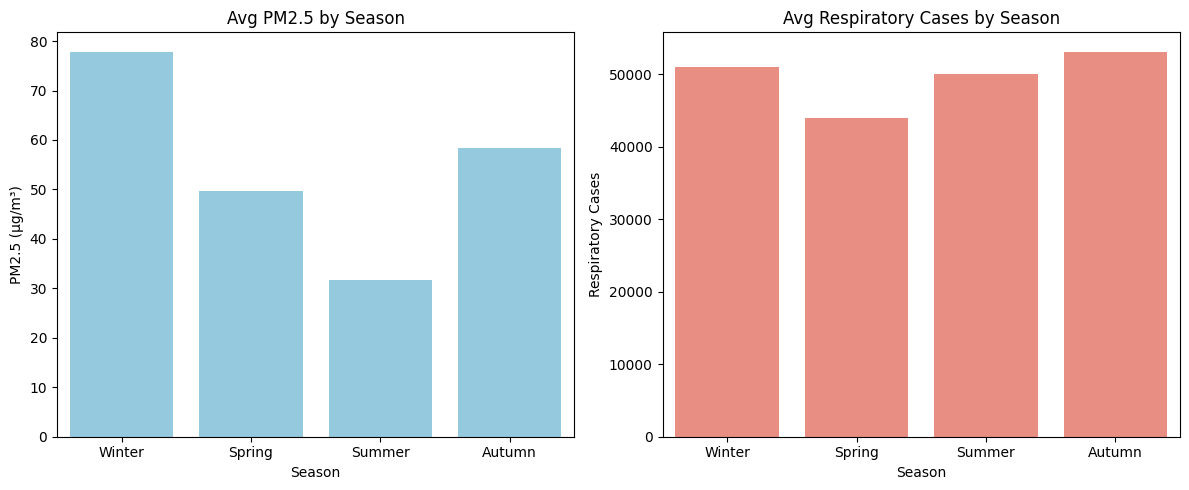

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Derive season from month
# Define season mapping: DJF=Winter(1), MAM=Spring(2), JJA=Summer(3), SON=Autumn(4)
def month_to_season(m):
    if m in [12,  1,  2]: return 'Winter'
    if m in [3,   4,  5]: return 'Spring'
    if m in [6,   7,  8]: return 'Summer'
    return 'Autumn'

merged_df['season_name'] = merged_df['month'].apply(lambda x: month_to_season(x))

# 2. Aggregate by season
seasonal = merged_df.groupby('season_name').agg({
    'pm25': 'mean',
    'respiratory_cases': 'mean'
}).reindex(['Winter','Spring','Summer','Autumn']).reset_index()

# 3. Plot side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=seasonal, x='season_name', y='pm25', ax=ax1, color='skyblue')
ax1.set_title('Avg PM2.5 by Season')
ax1.set_xlabel('Season')
ax1.set_ylabel('PM2.5 (µg/m³)')

sns.barplot(data=seasonal, x='season_name', y='respiratory_cases', ax=ax2, color='salmon')
ax2.set_title('Avg Respiratory Cases by Season')
ax2.set_xlabel('Season')
ax2.set_ylabel('Respiratory Cases')

plt.tight_layout()
plt.show()


In [63]:
merged_df.columns


Index(['state', 'year', 'month', 'pm25', 'pm10', 'aqi', 'respiratory_cases',
       'mortality'],
      dtype='object')

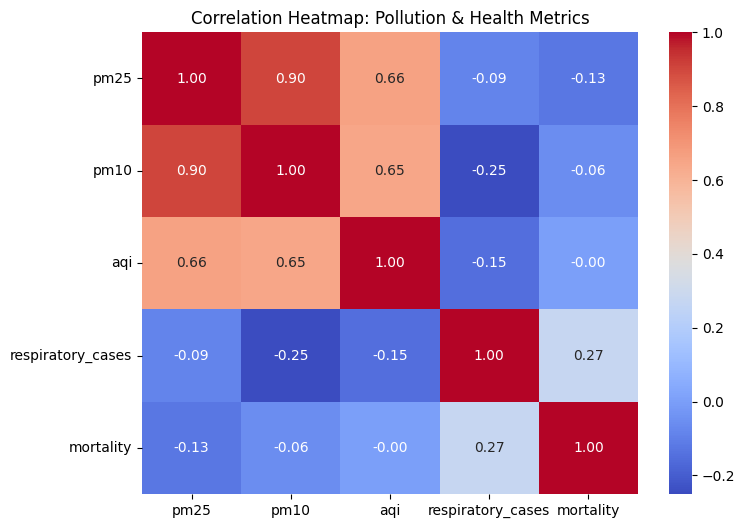

In [66]:
plt.figure(figsize=(8,6))
corr = merged_df[["pm25", "pm10", "aqi", "respiratory_cases", "mortality"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Pollution & Health Metrics")
plt.show()


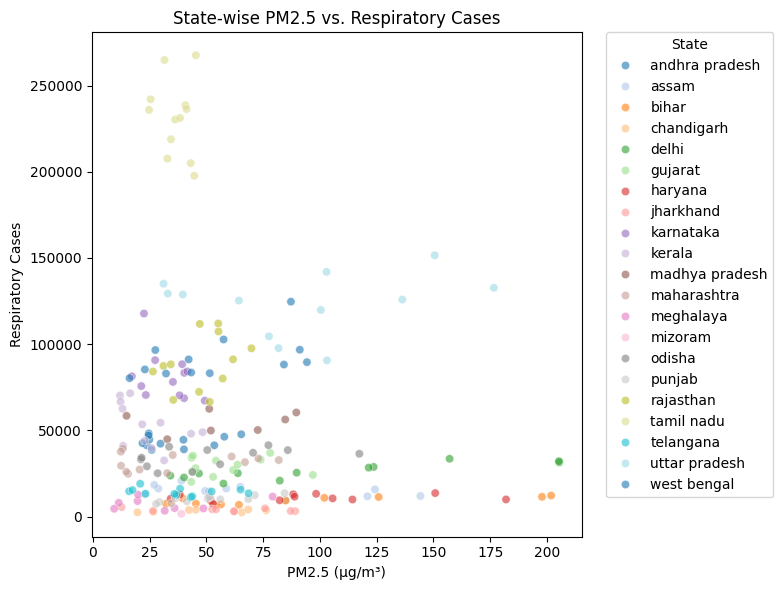

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=merged_df,
    x='pm25',
    y='respiratory_cases',
    hue='state',
    palette='tab20',
    alpha=0.6
)
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Respiratory Cases')
plt.title('State-wise PM2.5 vs. Respiratory Cases')

# Place legend outside plot
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
